In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/sample_data/data.csv")


In [5]:
x = df["no2"].dropna().values
x = x.astype(np.float32)

In [6]:
r = 102316119

In [7]:
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

In [8]:
z = x + a_r * np.sin(b_r * x)

In [9]:
z = z.reshape(-1, 1)

In [10]:
mean = z.mean()
std = z.std()

z = (z - mean) / std

In [13]:
pip install torch torchvision torchaudio

In [14]:
pip install torch

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
import torch
print(torch.__version__)

2.9.0+cpu


In [17]:
z_tensor = torch.tensor(z, dtype=torch.float32)

In [18]:
latent_dim = 5

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [22]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

In [23]:
print(G)
print(D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [24]:
epochs = 3000
batch_size = 64

In [25]:
for epoch in range(epochs):
    idx = np.random.randint(0, z_tensor.shape[0], batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    noise = torch.randn(batch_size, latent_dim).to(device)
    fake_samples = G(noise)

    optimizer_D.zero_grad()

    output_real = D(real_samples)
    loss_real = criterion(output_real, real_labels)

    output_fake = D(fake_samples.detach())
    loss_fake = criterion(output_fake, fake_labels)

    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()

    output = D(fake_samples)
    loss_G = criterion(output, real_labels)  # trick D

    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3968 | G Loss: 0.8126
Epoch 500 | D Loss: 1.5220 | G Loss: 0.5487
Epoch 1000 | D Loss: 1.4421 | G Loss: 0.6042
Epoch 1500 | D Loss: 1.3427 | G Loss: 0.8383
Epoch 2000 | D Loss: 1.3167 | G Loss: 0.6997
Epoch 2500 | D Loss: 1.3609 | G Loss: 0.6742


In [26]:
with torch.no_grad():
    noise = torch.randn(10000, latent_dim).to(device)
    generated = G(noise)

generated = generated.cpu().numpy()


In [27]:
generated = generated * std + mean

In [28]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [29]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(generated)

z_range = np.linspace(generated.min(), generated.max(), 1000).reshape(-1,1)
log_density = kde.score_samples(z_range)
density = np.exp(log_density)

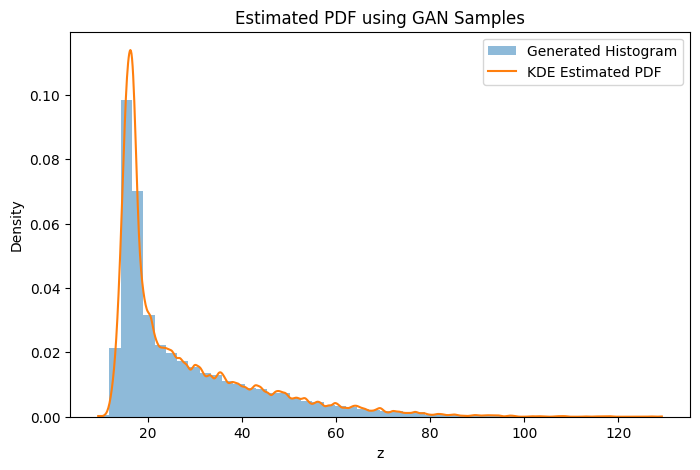

In [30]:
plt.figure(figsize=(8,5))

plt.hist(generated, bins=50, density=True, alpha=0.5, label="Generated Histogram")
plt.plot(z_range, density, label="KDE Estimated PDF")

plt.title("Estimated PDF using GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()